## Load functions, dask cluster, and data

In [12]:
%load_ext autoreload
%autoreload 2
from processing_imports_and_functions import *

print(os.getcwd())

# Configure dask cluster (adjust n_workers & memory_limit as needed)
cluster = LocalCluster(
    n_workers=10,           
    threads_per_worker=1,       
    memory_limit='7GB',     # 10 workers * 7GB = 70GB max RAM
    dashboard_address=':8787'
)

client = cluster.get_client()
print(f"Dashboard: {client.dashboard_link}")

# Import Channels
C_AXIS, Y_AXIS, X_AXIS = 2, 3, 4 # channel, y, x (adjust as needed)
with open("config.json", "r") as f:
    config = json.load(f)
channels = config["channels"]
channel_indices = config["channel_indices"]

# Load Data
images = da.from_zarr("trenches.zarr")
masks = da.from_zarr("masks_upscaled_filtered.zarr")

print(f"Images: {images.shape}, Masks: {masks.shape}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/mnt/ka_gh_storage/2025_11_27_40x_persister_1HourAmpicillinTreatments


/home/ka537/miniconda3/envs/extraction/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42507 instead
  warnings.warn(


Dashboard: http://127.0.0.1:42507/status
Images: (60420, 321, 1, 135, 24), Masks: (60420, 321, 1, 270, 48)


## Align fluorescence channels to masks, to correct for chromatic aberration (skip if no fluorescence channels)

--- Running Test Alignment on IDs: [239, 1695, 1777] ---
Running alignment calculation...
Alignment Complete.
Sampling 3 locations...


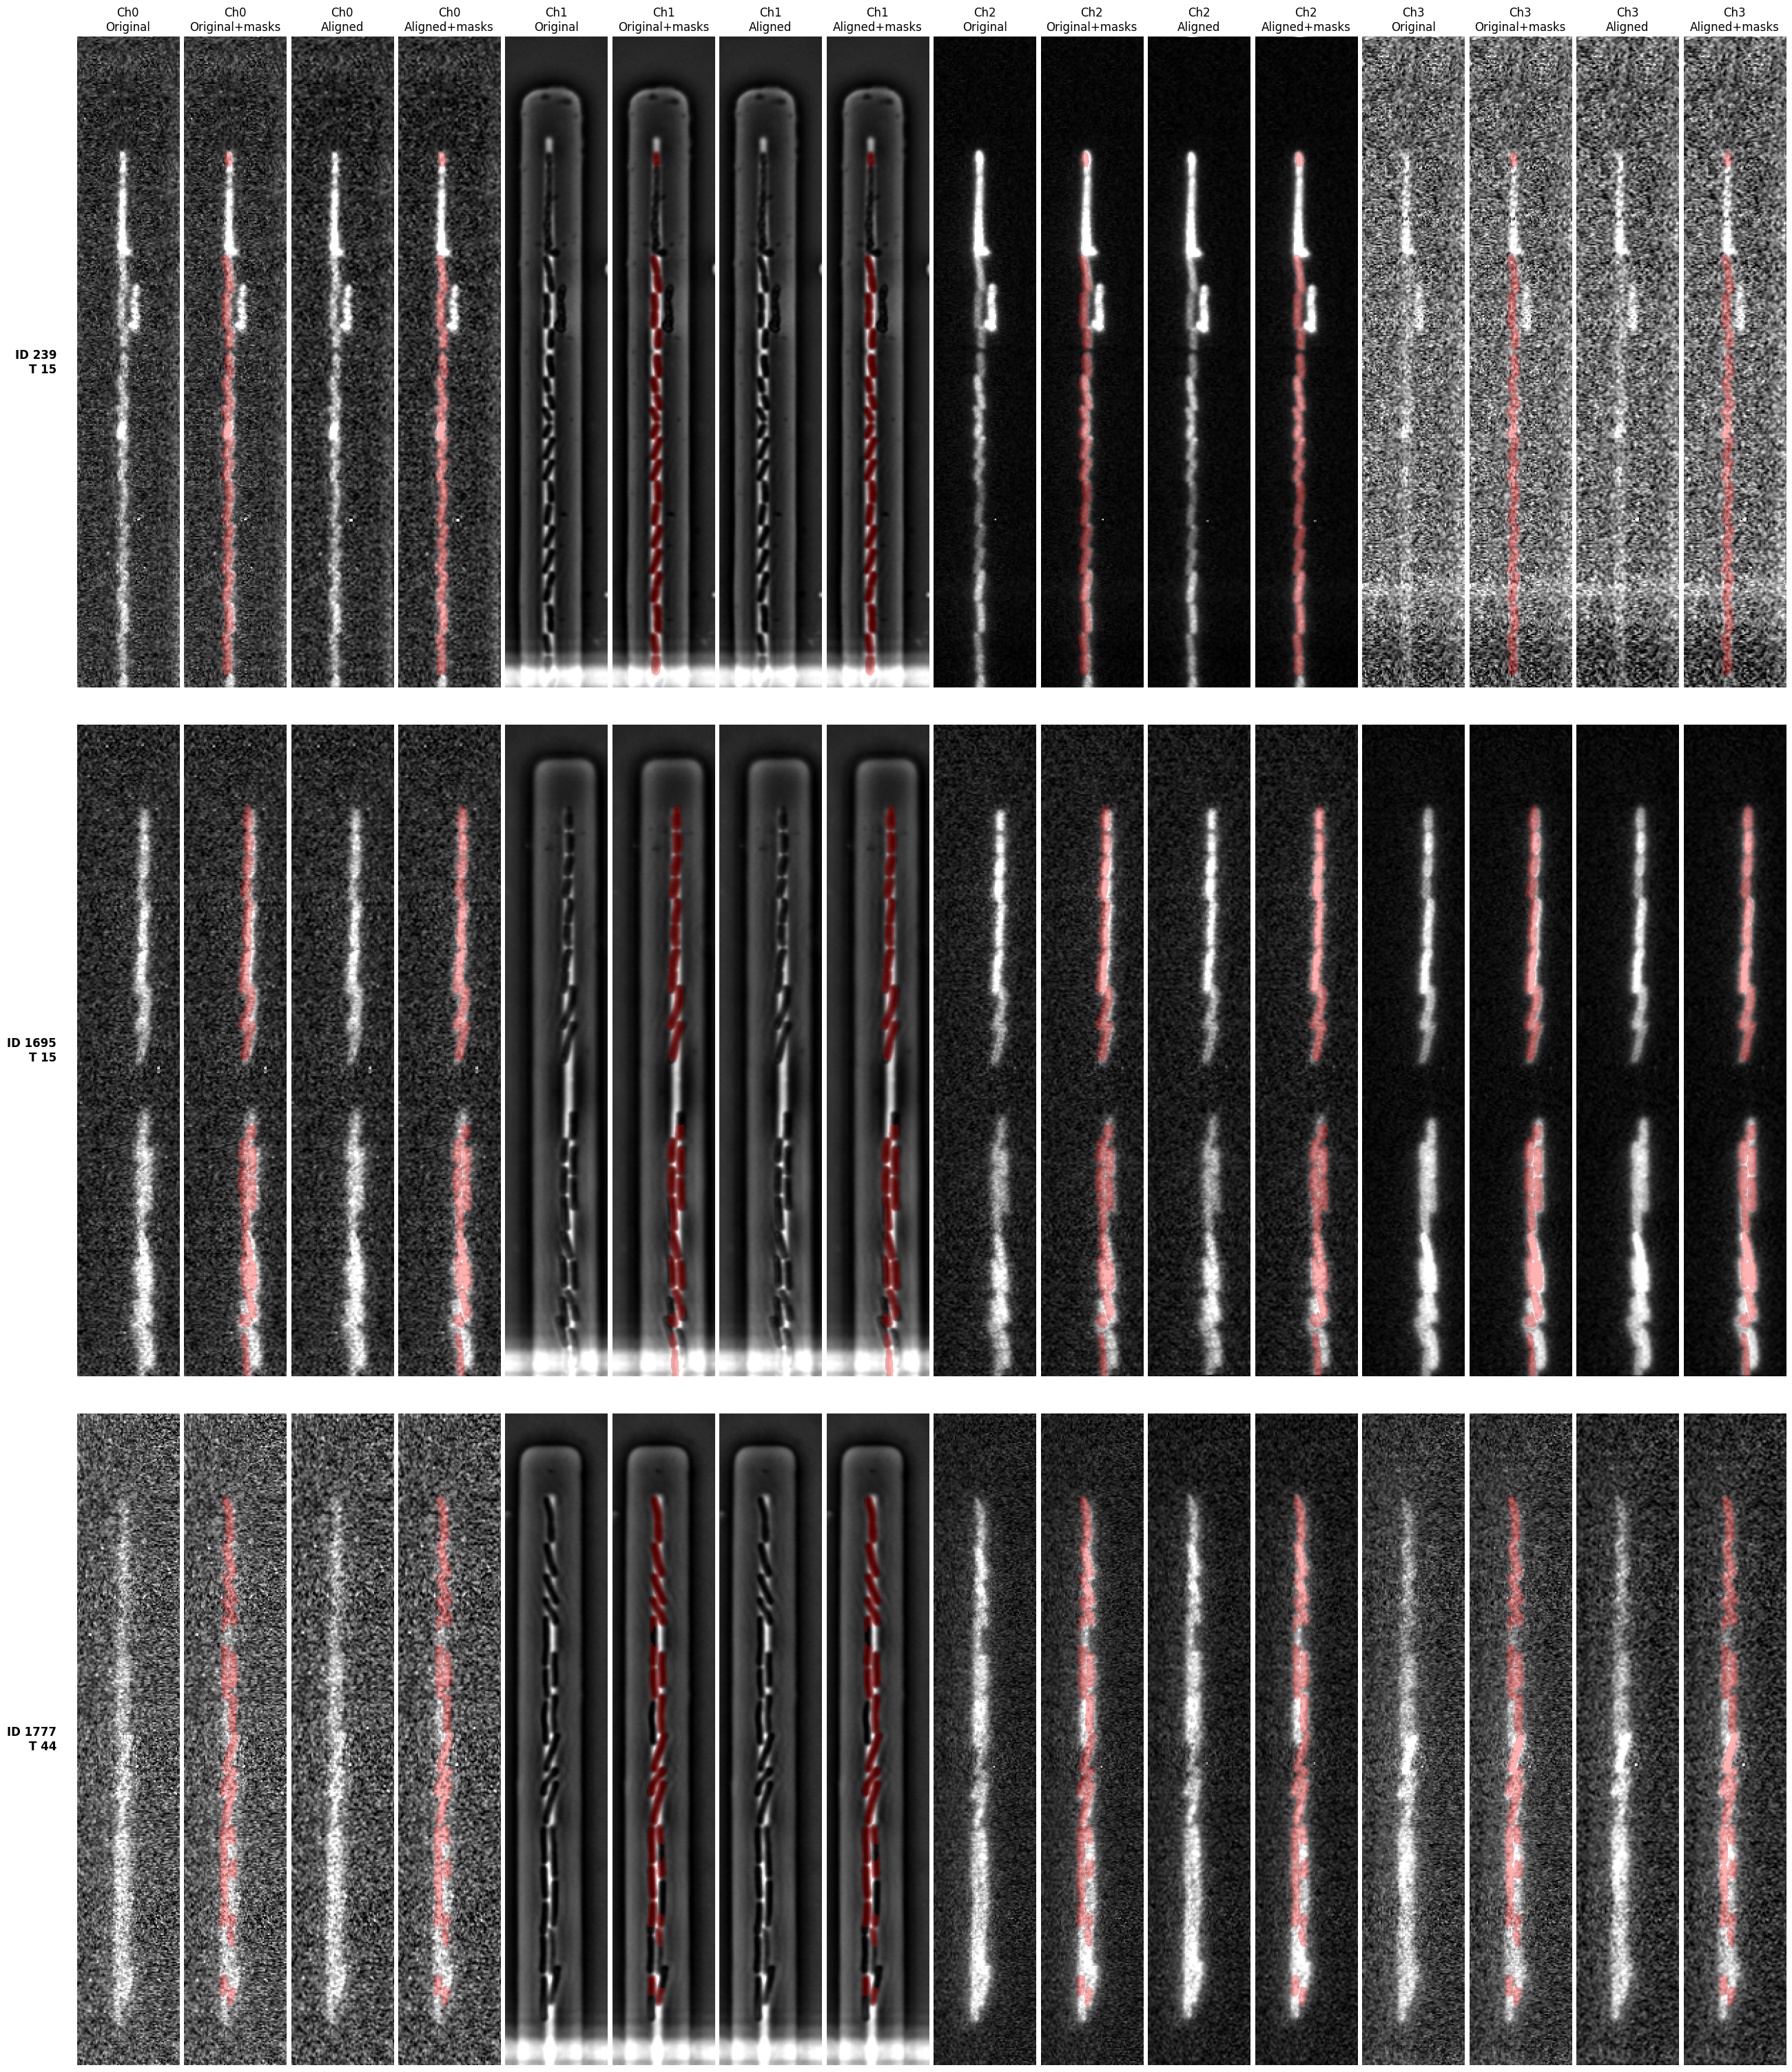

In [5]:
# Test that alignment works well (modify ALIGNMENT_PADDING as needed)
ALIGNMENT_PADDING = 8   # Default is 8 for 2x2 upscaled 40x images. Increase/decrease if shifts are larger/smaller.
NUM_TEST_IDS = 3        # number of random mother_ids to test

run_alignment_test(images, masks, channels, padding=ALIGNMENT_PADDING, n_test_ids=NUM_TEST_IDS)

In [3]:
# If alignment looks good, proceed to run for all:

In [7]:
# Process alignment for all mother_ids
ALIGNED_TRENCHES_PATH = "aligned_trenches.zarr"

run_batch_alignment(images, masks, ALIGNED_TRENCHES_PATH, channels, padding=ALIGNMENT_PADDING, client=client)

--- Processing FULL Dataset (Padding=8) ---
Writing to Zarr...
Cluster: http://127.0.0.1:42339/status
Done.


## Extract data from (aligned) images

In [ ]:
# TO-DO: modify to also extract number of masks (for looking at trench occupancy)

In [2]:
# Extract image data from corresponding masks (masks ONLY, extract background data later)
EXTRACT_FEATURES = ['area', 'length', 'width', 'solidity', 'intensity'] # 'area', 'length', 'width', 'solidity', 'intensity']
TRENCHES_PATH = 'trenches.zarr'
MASKS_PATH = 'masks_upscaled_filtered.zarr'
UPSCALE = True                                                          # Set True for 2x2 upscaled images, False for not upscaled

mother_machine_data = run_feature_extraction(TRENCHES_PATH, MASKS_PATH, channels, channel_indices, EXTRACT_FEATURES, UPSCALE)

mother_machine_data

--- Starting Feature Extraction (Dask) ---
Using Cluster: http://127.0.0.1:8787/status
Generated 795 tasks (Chunks). Computing...

Aggregating results into DataFrame...
Extraction Complete. Time taken: 0h 30m 28.39s


mother_id  timepoint channel  intensity_raw    area      length  \
0                1          0      PC   17302.495798   238.0   21.011391   
1                1          1      PC   15659.485849   212.0   19.207739   
2                1          2      PC   14906.520000   225.0   19.623338   
3                1          3      PC   17494.124000   250.0   21.683433   
4                1          4      PC   17292.062222   225.0   20.194289   
...            ...        ...     ...            ...     ...         ...   
8722790      60417        316      PC   22496.348794   539.0   55.094898   
8722791      60417        317      PC   25842.098592    71.0   15.070014   
8722792      60417        318      PC   22504.790859  1444.0  149.013273   
8722793      60417        319      PC   24697.387634   841.0   86.386918   
8722794      60417        320      PC   22992.988372  1462.0  146.920484   

             width  solidity  
0        14.439945  0.955823  
1        14.056254  0.954955  
2        14.632023  0.949367  
3        14.713107  0.965251  
4        14.181786  0.957447  
...            ...       ...  
8722790  12.848757  0.967684  
8722791   6.345881  0.898734  
8722792  13.691116  0.853428  
8722793  12.859846  0.928256  
8722794  13.101176  0.924147  

[8722795 rows x 8 columns]

## Fluorescence background intensity subtraction (skip if no fluorescence channels)

### Define region to use for background subtraction

Checking Background Logic: {'buffer_from_cell': 10, 'region_height': 50, 'side_margin': 25}


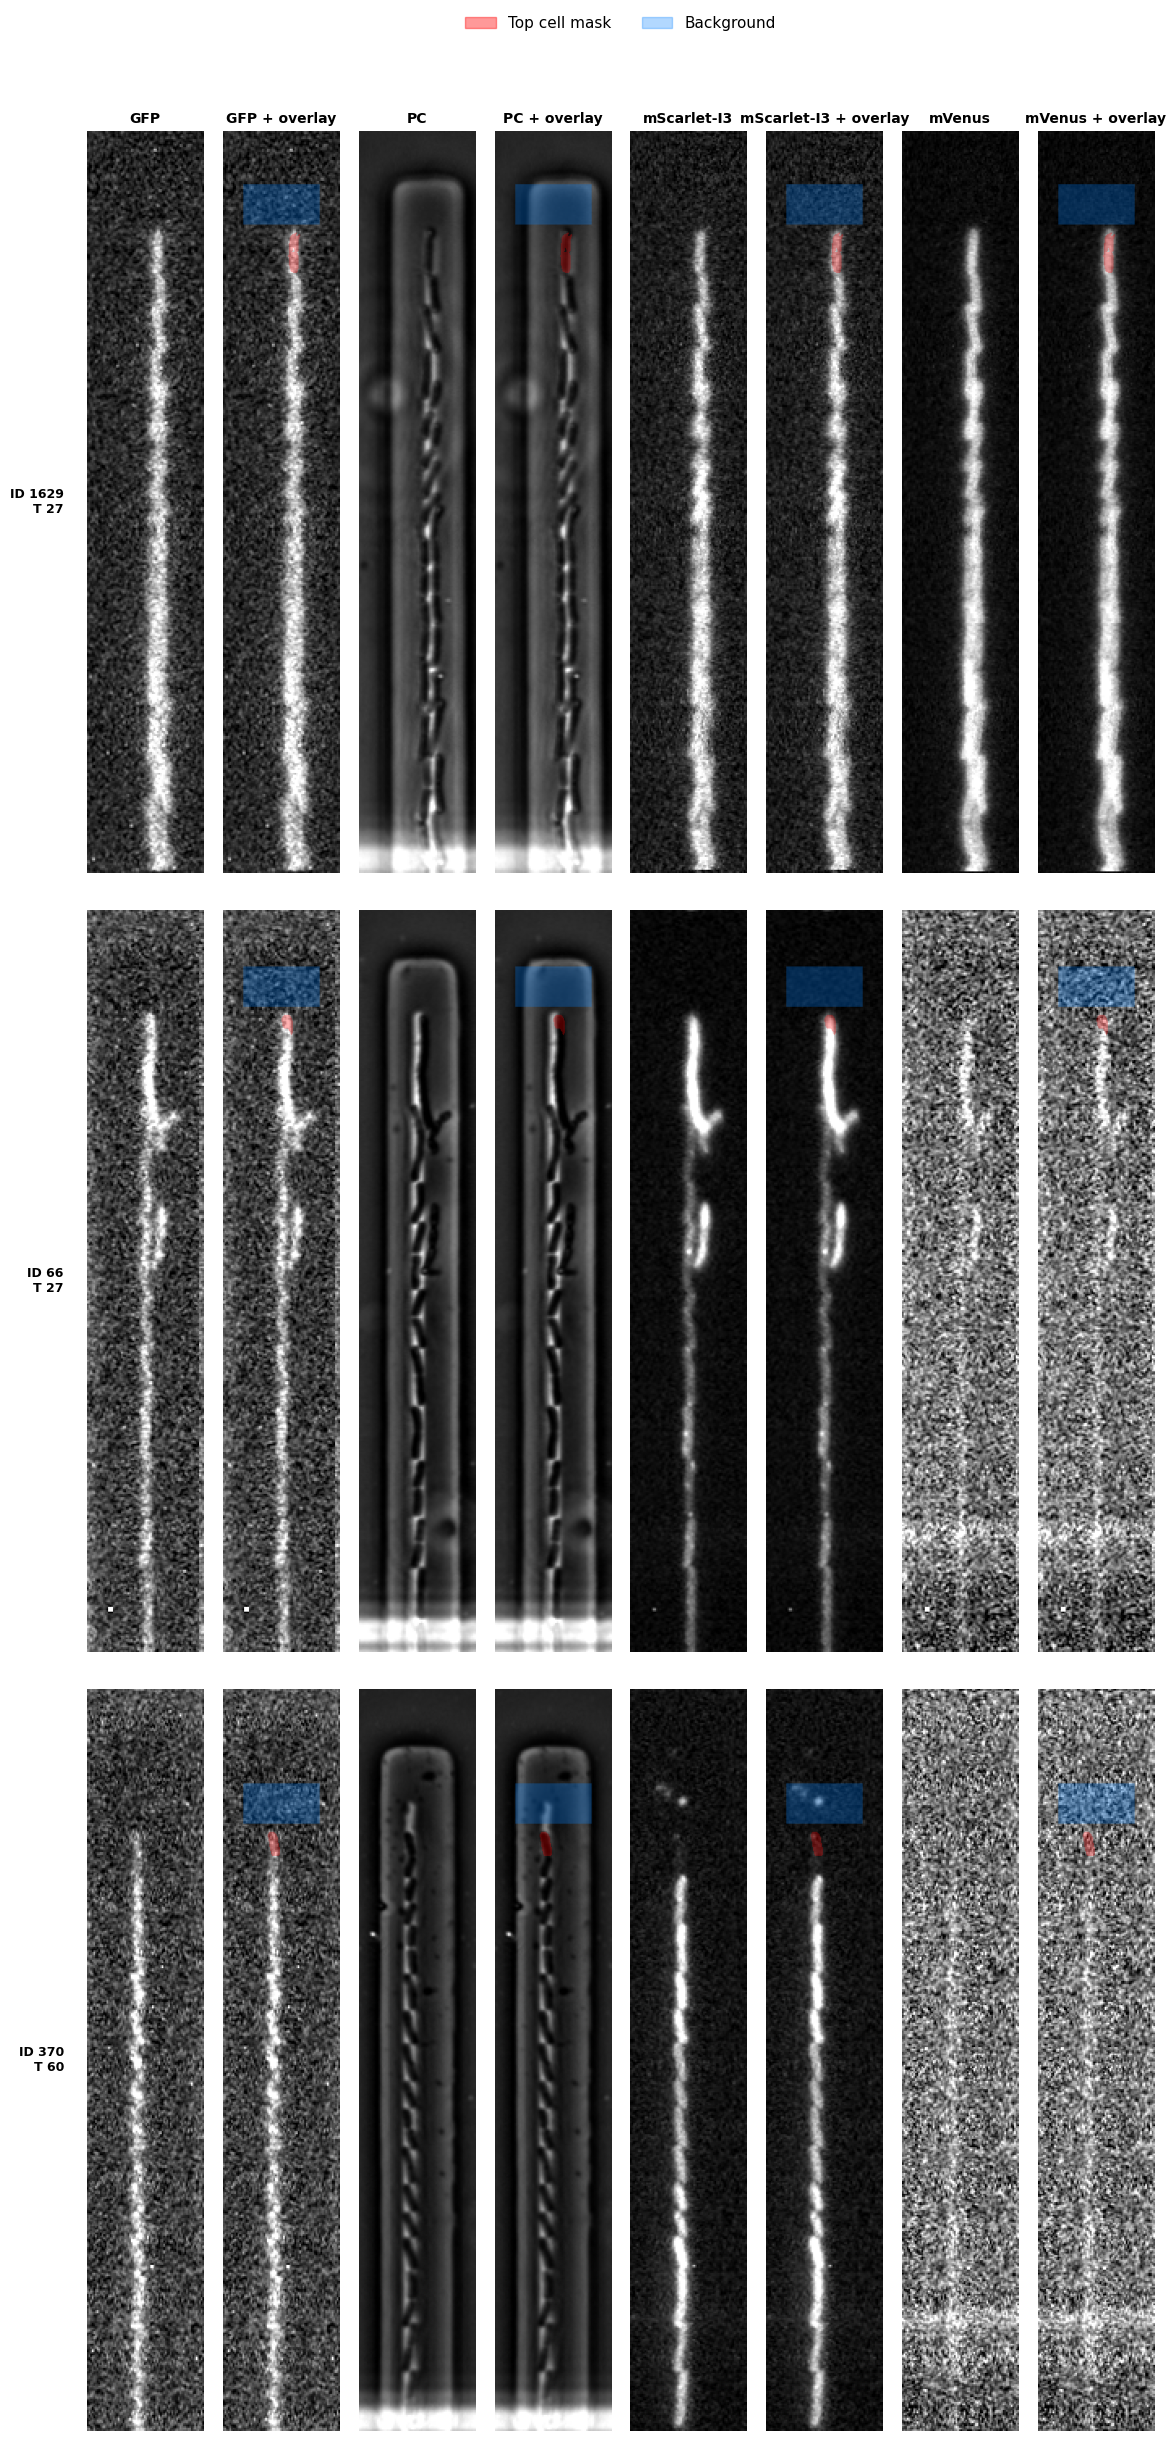

In [19]:
# Define region to use for background intensity calculations
bg_settings = {
    'buffer_from_cell': 10,   # Pixels above the top cell to END the background region
    'region_height': 50,      # Height of the background box (in pixels)
    'side_margin': 25         # Pixels to exclude on left/right edges
}

# Run
visualize_background_logic(trenches_path=ALIGNED_TRENCHES_PATH, masks_path=MASKS_PATH, channels=channels, channel_indices=channel_indices, n_samples=NUM_TEST_IDS, bg_settings=bg_settings, upscale=UPSCALE)

In [7]:
# Extract background and append to mother_machine_data
# (I HAVEN'T TESTED THIS DASK VERSION WITH FLUOR DATA YET, MIGHT NEED TWEAKING!)
df_bg = run_background_extraction(TRENCHES_PATH, MASKS_PATH, channels, channel_indices, bg_settings, UPSCALE)
mother_machine_data = merge_background_data(mother_machine_data, df_bg)

mother_machine_data

--- Starting Background Extraction (Dask) ---
Using Cluster: http://127.0.0.1:45147/status
Generated 795 tasks. Computing...
Background Extraction Complete. Time: 6m 57.07s


mother_id  timepoint channel  intensity_raw    area      length  \
0                1          0      PC   17302.495798   238.0   21.011391   
1                1          1      PC   15659.485849   212.0   19.207739   
2                1          2      PC   14906.520000   225.0   19.623338   
3                1          3      PC   17494.124000   250.0   21.683433   
4                1          4      PC   17292.062222   225.0   20.194289   
...            ...        ...     ...            ...     ...         ...   
8722790      60417        316      PC   22496.348794   539.0   55.094898   
8722791      60417        317      PC   25842.098592    71.0   15.070014   
8722792      60417        318      PC   22504.790859  1444.0  149.013273   
8722793      60417        319      PC   24697.387634   841.0   86.386918   
8722794      60417        320      PC   22992.988372  1462.0  146.920484   

             width  solidity  
0        14.439945  0.955823  
1        14.056254  0.954955  
2        14.632023  0.949367  
3        14.713107  0.965251  
4        14.181786  0.957447  
...            ...       ...  
8722790  12.848757  0.967684  
8722791   6.345881  0.898734  
8722792  13.691116  0.853428  
8722793  12.859846  0.928256  
8722794  13.101176  0.924147  

[8722795 rows x 8 columns]

## Add timing, convert px to µm, log transforms etc.

In [8]:
# Add time
t0_time = 0   # minutes
time_step = 3 # minutes

mother_machine_data['time'] = t0_time + (mother_machine_data['timepoint'] * time_step)

In [10]:
# Convert px to um
PIXEL_SIZE_UM = 0.1618 # µm per pixel (ignoring upscaling)
UPSCALE_FACTOR = 2     # 2x2 upscaled, change to 1 for non-upscaled

mother_machine_data = convert_px_to_microns(mother_machine_data, pixel_size_um=PIXEL_SIZE_UM, upscale=UPSCALE_FACTOR)
    
mother_machine_data

Data is already in µm. Skipping conversion.


mother_id  timepoint channel  intensity_raw      area     length  \
0                1          0      PC   17302.495798  1.557665   1.699821   
1                1          1      PC   15659.485849  1.387500   1.553906   
2                1          2      PC   14906.520000  1.472582   1.587528   
3                1          3      PC   17494.124000  1.636203   1.754190   
4                1          4      PC   17292.062222  1.472582   1.633718   
...            ...        ...     ...            ...       ...        ...   
8722790      60417        316      PC   22496.348794  3.527653   4.457177   
8722791      60417        317      PC   25842.098592  0.464682   1.219164   
8722792      60417        318      PC   22504.790859  9.450706  12.055174   
8722793      60417        319      PC   24697.387634  5.504185   6.988702   
8722794      60417        320      PC   22992.988372  9.568512  11.885867   

            width  solidity  time  log_length  log_area  
0        1.168192  0.955823     0    0.530523  0.443188  
1        1.137151  0.954955     3    0.440772  0.327503  
2        1.183731  0.949367     6    0.462178  0.387017  
3        1.190290  0.965251     9    0.562007  0.492378  
4        1.147306  0.957447    12    0.490858  0.387017  
...           ...       ...   ...         ...       ...  
8722790  1.039464  0.967684   948    1.494516  1.260633  
8722791  0.513382  0.898734   951    0.198165 -0.766403  
8722792  1.107611  0.853428   954    2.489494  2.246089  
8722793  1.040362  0.928256   957    1.944295  1.705509  
8722794  1.059885  0.924147   960    2.475350  2.258478  

[8722795 rows x 11 columns]

In [13]:
# Re-order columns
TARGET_ORDER = [
    'mother_id', 'timepoint', 'time',             
    'length', 'width', 'area',                    
    'log_length', 'log_area',                     
    'channel',                                    
    'intensity_raw', 'intensity_bg', 'intensity', 
    'solidity'                                    
]

mother_machine_data = reorder_dataframe(mother_machine_data, TARGET_ORDER)

mother_machine_data

Columns reordered.


mother_id  timepoint  time     length     width      area  \
0                1          0     0   1.699821  1.168192  1.557665   
1                1          1     3   1.553906  1.137151  1.387500   
2                1          2     6   1.587528  1.183731  1.472582   
3                1          3     9   1.754190  1.190290  1.636203   
4                1          4    12   1.633718  1.147306  1.472582   
...            ...        ...   ...        ...       ...       ...   
8722790      60417        316   948   4.457177  1.039464  3.527653   
8722791      60417        317   951   1.219164  0.513382  0.464682   
8722792      60417        318   954  12.055174  1.107611  9.450706   
8722793      60417        319   957   6.988702  1.040362  5.504185   
8722794      60417        320   960  11.885867  1.059885  9.568512   

         log_length  log_area channel  intensity_raw  solidity  
0          0.530523  0.443188      PC   17302.495798  0.955823  
1          0.440772  0.327503      PC   15659.485849  0.954955  
2          0.462178  0.387017      PC   14906.520000  0.949367  
3          0.562007  0.492378      PC   17494.124000  0.965251  
4          0.490858  0.387017      PC   17292.062222  0.957447  
...             ...       ...     ...            ...       ...  
8722790    1.494516  1.260633      PC   22496.348794  0.967684  
8722791    0.198165 -0.766403      PC   25842.098592  0.898734  
8722792    2.489494  2.246089      PC   22504.790859  0.853428  
8722793    1.944295  1.705509      PC   24697.387634  0.928256  
8722794    2.475350  2.258478      PC   22992.988372  0.924147  

[8722795 rows x 11 columns]

In [14]:
# Define lane numbers and map to different conditions
lane_to_condition = {
    0: "Fresh media",
    1: "2.5 μg/mL ampicillin, 1 hour",
    2: "10 μg/mL ampicillin, 1 hour",
    3: "50 μg/mL ampicillin, 1 hour"
}

# TO-DO: modify logic to work with updated PyMMM (e.g. real FOV numbers and lane numbers saved to JSON?)
num_FOVs_per_lane = 42*5 # change to actual number

with open("config.json", "r") as f:
    config = json.load(f)
discard_FOVs = config["discard_FOVs"] 

chunk_size = images.chunks[0][0]
mother_machine_data = mother_machine_data.copy()
mother_machine_data["FOV_number"] = mother_machine_data["mother_id"]//chunk_size

# 1. Define valid FOVs based on (conditions * FOVs/lane) excluding discards
max_fovs = len(lane_to_condition) * num_FOVs_per_lane
valid_FOVs = [i for i in range(max_fovs) if i not in discard_FOVs]

# 2. Correct FOV numbers
if mother_machine_data['FOV_number'].max() < len(valid_FOVs):
    mother_machine_data['FOV_number'] = mother_machine_data['FOV_number'].map(dict(enumerate(valid_FOVs)))

# 3. Assign Lane and Condition
mother_machine_data['lane'] = mother_machine_data['FOV_number'] // num_FOVs_per_lane
mother_machine_data['condition'] = mother_machine_data['lane'].map(lane_to_condition)

mother_machine_data

mother_id  timepoint  time     length     width      area  \
0                1          0     0   1.699821  1.168192  1.557665   
1                1          1     3   1.553906  1.137151  1.387500   
2                1          2     6   1.587528  1.183731  1.472582   
3                1          3     9   1.754190  1.190290  1.636203   
4                1          4    12   1.633718  1.147306  1.472582   
...            ...        ...   ...        ...       ...       ...   
8722790      60417        316   948   4.457177  1.039464  3.527653   
8722791      60417        317   951   1.219164  0.513382  0.464682   
8722792      60417        318   954  12.055174  1.107611  9.450706   
8722793      60417        319   957   6.988702  1.040362  5.504185   
8722794      60417        320   960  11.885867  1.059885  9.568512   

         log_length  log_area channel  intensity_raw  solidity  FOV_number  \
0          0.530523  0.443188      PC   17302.495798  0.955823           0   
1          0.440772  0.327503      PC   15659.485849  0.954955           0   
2          0.462178  0.387017      PC   14906.520000  0.949367           0   
3          0.562007  0.492378      PC   17494.124000  0.965251           0   
4          0.490858  0.387017      PC   17292.062222  0.957447           0   
...             ...       ...     ...            ...       ...         ...   
8722790    1.494516  1.260633      PC   22496.348794  0.967684         839   
8722791    0.198165 -0.766403      PC   25842.098592  0.898734         839   
8722792    2.489494  2.246089      PC   22504.790859  0.853428         839   
8722793    1.944295  1.705509      PC   24697.387634  0.928256         839   
8722794    2.475350  2.258478      PC   22992.988372  0.924147         839   

         lane                    condition  
0           0                  Fresh media  
1           0                  Fresh media  
2           0                  Fresh media  
3           0                  Fresh media  
4           0                  Fresh media  
...       ...                          ...  
8722790     3  50 μg/mL ampicillin, 1 hour  
8722791     3  50 μg/mL ampicillin, 1 hour  
8722792     3  50 μg/mL ampicillin, 1 hour  
8722793     3  50 μg/mL ampicillin, 1 hour  
8722794     3  50 μg/mL ampicillin, 1 hour  

[8722795 rows x 14 columns]

In [34]:
# Check
summary = mother_machine_data.groupby(['lane', 'condition']).agg(unique_FOV_numbers=('FOV_number', 'nunique'), unique_mother_ids=('mother_id', 'nunique')).reset_index().sort_values('lane', key=lambda x: pd.to_numeric(x, errors='coerce'))
summary.style.hide(axis='index')

In [35]:
mother_machine_data.to_pickle("mother_machine_data_2025_11_27.pickle")

In [36]:
# Folder cleanup
# 1. Define list of folders to delete unconditionally
folders_to_delete = [
    "zarr_lock_file.lock",
    "diagnostics",
    "extracted",
    "registered",          # Make sure that you don't still need these before deleting!
    "masks_upscaled.zarr"  # The non-filtered version
]

# 2. Safety Check: Only delete trenches.zarr if the aligned version exists
if os.path.exists("aligned_trenches.zarr"):
    folders_to_delete.append("trenches.zarr")
else:
    print("Skipping 'trenches.zarr' deletion: 'aligned_trenches.zarr' not found.")

# 3. Execute Deletion
print("Cleaning up intermediate folders...")
for folder_path in folders_to_delete:
    if os.path.exists(folder_path):
        try:
            shutil.rmtree(folder_path)
            print(f"  - Deleted: {folder_path}")
        except Exception as e:
            print(f"  ! Failed to delete {folder_path}: {e}")

Skipping 'trenches.zarr' deletion: 'aligned_trenches.zarr' not found.
Cleaning up intermediate folders...
  - Deleted: zarr_lock_file.lock
  - Deleted: masks_upscaled.zarr


In [37]:
#